# Model to predict the goals

### Libraries

In [83]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data management
import pandas as pd
import numpy as np
import pickle as pkl

from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Deep Learning
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, InputLayer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, mean_squared_error, mean_absolute_error

### Data

In [84]:
results = pd.read_csv('./data/stats_det.csv', parse_dates=['date'])
results.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,importance,...,home_ga_away_recent,away_points_away_recent,away_performance_away_recent,away_gf_away_recent,away_ga_away_recent,neutral_points_away_recent,neutral_performance_away_recent,neutral_gf_away_recent,neutral_ga_away_recent,h2h
32843,2009-04-01,Czech Republic,Slovakia,1.0,2.0,FIFA World Cup qualification,Prague,Czech Republic,0,6,...,1.156250,324.0,0.490741,1.606061,1.424242,27.0,0.259259,1.00,1.444444,6.0
18812,1993-03-31,Hungary,Greece,0.0,1.0,FIFA World Cup qualification,Budapest,Hungary,0,6,...,1.264706,234.0,0.645299,1.617647,0.764706,3.0,1.000000,1.00,0.000000,-3.0
3655,1953-02-25,Bolivia,Uruguay,0.0,2.0,Copa América,Lima,Peru,1,7,...,1.000000,90.0,0.366667,2.333333,2.555556,357.0,0.593838,2.95,1.850000,-9.0
10714,1976-11-12,Haiti,United States,0.0,0.0,Friendly,Port-au-Prince,Haiti,0,1,...,1.400000,51.0,0.862745,2.882353,0.470588,6.0,0.000000,0.50,4.500000,0.0
10557,1976-07-05,Cameroon,DR Congo,2.0,1.0,Friendly,Libreville,Gabon,1,1,...,0.357143,129.0,0.372093,1.176471,1.705882,276.0,0.257246,1.55,2.050000,0.0


### Input

In [95]:
# Filter out older results
res = results[results['date'].dt.year>=1960]
#('date', 'tournament', 'city', 'country')
#col in ('home_team', 'away_team', 'winner', 'home_score', 'away_score', 'neutral', 'importance', 'h2h')
df_input = res[[col for col in results.columns.tolist() if  col not in ('date', 'tournament', 'city', 'country')]].fillna(0)

print(df_input.shape)
df_input.sample(5)

(42133, 72)


,home_team,away_team,home_score,away_score,neutral,importance,winner,points_home,performance_home,gf_home,...,home_ga_away_recent,away_points_away_recent,away_performance_away_recent,away_gf_away_recent,away_ga_away_recent,neutral_points_away_recent,neutral_performance_away_recent,neutral_gf_away_recent,neutral_ga_away_recent,h2h
31668,British Virgin Islands,United States Virgin Islands,0.0,0.0,0,1,0,234.0,0.21,1.02,...,5.333333,39.0,1.000000,6.250000,0.625000,15.0,0.066667,0.200000,8.200,0.0
21375,England,Poland,2.0,1.0,0,6,1,4869.0,0.62,2.31,...,1.205882,279.0,0.555556,1.404762,0.976190,33.0,0.454545,1.125000,1.000,6.0
38817,Gibraltar,Ynys Môn,1.0,1.0,1,1,0,240.0,0.38,2.15,...,0.000000,3.0,1.000000,4.000000,0.000000,24.0,0.500000,2.250000,2.375,0.0
10377,Japan,Bulgaria,0.0,3.0,0,1,-1,651.0,0.38,1.87,...,0.923077,243.0,0.452675,1.421053,1.684211,198.0,0.181818,1.000000,2.000,0.0
45760,Ethiopia,Rwanda,1.0,0.0,0,1,1,2154.0,0.38,1.38,...,0.904762,87.0,0.689655,1.357143,0.642857,33.0,0.181818,0.666667,1.000,0.0


In [112]:
X_train, X_test, y, yt = train_test_split(df_input.drop(['home_score', 'away_score', 'winner'], axis=1), 
                                          df_input[['home_score', 'away_score', 'winner']], test_size=.1, random_state=42)

y_win, yt_win = y.winner, yt.winner
y, yt = y.drop(columns=['winner'], axis=1), yt.drop(columns=['winner'], axis=1)

### Scale objective

In [111]:
# y_scaler = StandardScaler()
# y = y_scaler.fit_transform(y)
# yt = y_scaler.transform(yt)

#### Scale data

In [113]:
X = X_train.drop(['home_team', 'away_team'], axis=1).replace([np.inf, -np.inf], 0.0)
Xt = X_test.drop(['home_team', 'away_team'], axis=1).replace([np.inf, -np.inf], 0.0)

In [115]:
# Scale the data
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
scaled_cols = [col for col in X.columns if col in ('importance', 'h2h') or 'points' in col]
X_scaled = X.copy()
X_scaled[scaled_cols] = mm_scaler.fit_transform(X_scaled[scaled_cols])
Xt_scaled = Xt.copy()
Xt_scaled[scaled_cols] = mm_scaler.transform(Xt_scaled[scaled_cols])

In [116]:
oh_encoder = OneHotEncoder(drop='first')
oh_encoder.fit(df_input[['home_team', 'away_team']])

X_cat = X_train.drop(['home_team', 'away_team'], axis=1).reset_index(drop=True).replace([np.inf, -np.inf], 0.0)
X_cat = pd.concat([X_cat, pd.DataFrame(oh_encoder.transform(X_train[['home_team', 'away_team']]).toarray(), 
                                               columns=oh_encoder.get_feature_names_out())], axis=1)
X_cat[scaled_cols] = mm_scaler.fit_transform(X_cat[scaled_cols])

Xt_cat = X_test.drop(['home_team', 'away_team'], axis=1).reset_index(drop=True).replace([np.inf, -np.inf], 0.0)
Xt_cat = pd.concat([Xt_cat.reset_index(drop=True), pd.DataFrame(oh_encoder.transform(X_test[['home_team', 'away_team']]).toarray(), 
                                                 columns=oh_encoder.get_feature_names_out())], axis=1)
Xt_cat[scaled_cols] = mm_scaler.fit_transform(Xt_cat[scaled_cols])

#### PCA

In [117]:
pca = PCA(n_components=50)    # X_scaled.shape[1]
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_.cumsum())
Xt_pca = pca.transform(Xt_scaled)

[0.26775705 0.44534007 0.5435423  0.59218177 0.63846143 0.67651573
 0.71385816 0.74059785 0.76683289 0.79008366 0.8121005  0.83080913
 0.84795676 0.86323916 0.87594183 0.88708854 0.89769358 0.90760577
 0.91699732 0.92597218 0.93435838 0.94151441 0.94816709 0.95465409
 0.96031506 0.96555547 0.9692418  0.97245834 0.97541129 0.9781959
 0.98073124 0.98310732 0.98473319 0.98625516 0.98752864 0.98878287
 0.98993564 0.99103471 0.9920805  0.99301842 0.9938278  0.99459209
 0.99532092 0.99594808 0.99655454 0.9970679  0.99752119 0.9978486
 0.99814861 0.99842626]


In [118]:
pca_cat = PCA(n_components=200) # X_pca_cat.shape[1]
X_pca_cat = pca_cat.fit_transform(X_cat)
# X_pca_cat_res, y_pca_res = SMOTE().fit_resample(X_pca_cat, y)
for i, cumsum in enumerate(pca_cat.explained_variance_ratio_.cumsum()):
    if cumsum > .95:
        print(i, cumsum)
        break
print(pca_cat.explained_variance_ratio_.cumsum()[-1])
Xt_pca_cat = pca_cat.transform(Xt_cat)

157 0.9500432994495914
0.9609846349510412


### Models

In [104]:
def plot_confusion_matrix(y_true, y_pred):
    print(type(y_true), type(y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=['Away', 'Draw', 'Home'], yticklabels=['Away', 'Draw', 'Home'])
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

In [105]:
def plot_metrics(history: tf.keras.callbacks.History, metrics: list[str]) -> None:
    _, axs = plt.subplots(len(metrics), 1, sharex=True, figsize=(10, 8))
    if len(metrics) == 1:
        axs = [axs]
    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric], label=f'Train {metric.capitalize()}')
        axs[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        axs[i].set_title(f"{metric.capitalize()} vs. Epochs")
        axs[i].set_ylabel(f'{metric.capitalize()}')
        axs[i].legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.show()

In [119]:
# Set the input shape for the NN
tf.random.set_seed(1234)
input_shape = X_cat.shape[1]
backend.clear_session()

#### FNN

In [120]:
# backend.clear_session() 
model1 = Sequential()
model1.add(Dense(32, activation="silu", input_shape=(input_shape, )))   # , kernel_regularizer=tf.keras.regularizers.l2(.001)
model1.add(Dropout(.3))
model1.add(Dense(64, activation="silu")) 
model1.add(Dense(2, activation='softplus'))
# Create a callack to get the optimal learning rate
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
# For classification tasks, we can minimize categorical_crossentropy loss
model1.compile(loss="mse", metrics=["mse", 'mae'], 
               optimizer=tf.keras.optimizers.Nadam(learning_rate=.0001))
model1.summary()
history1 = model1.fit(X_cat, y, validation_split=.2, epochs=30, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                22368     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 24,610
Trainable params: 24,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
948/948 - 11s - loss: 2.2000 - mse: 2.2000 - mae: 1.0456 - val_loss: 1.9264 - val_mse: 1.9264 - val_mae: 0.9930 - 11s/epoch - 12ms/step
Epoch 2/30
948/948 - 5s - loss: 1.946

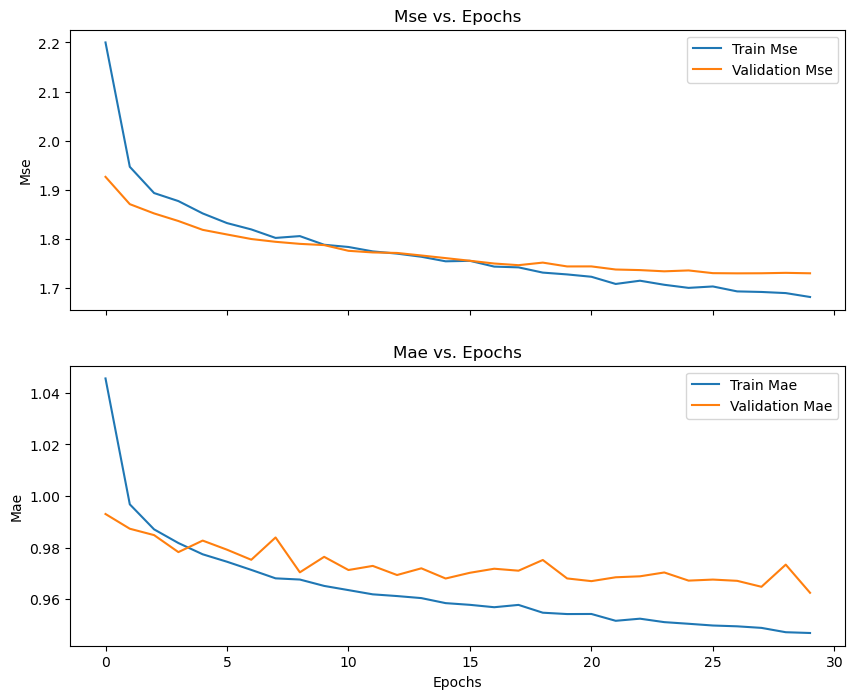

In [121]:
plot_metrics(history1, ["mse", 'mae'])

132/132 [==============================] - 0s 2ms/step
MSE: 1.299929929067499 MAE: 0.9441463231720388
0 -inf
[[ 547  288  295]
 [ 220  273  539]
 [ 179  322 1551]]
              precision    recall  f1-score   support

          -1       0.58      0.48      0.53      1130
           0       0.31      0.26      0.29      1032
           1       0.65      0.76      0.70      2052

    accuracy                           0.56      4214
   macro avg       0.51      0.50      0.50      4214
weighted avg       0.55      0.56      0.55      4214

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


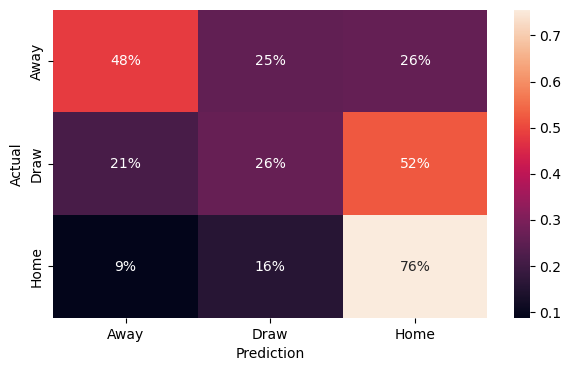

         home_team  away_team  home_score  away_score  home_xG  away_xG  0
35        Cambodia  Hong Kong         0.0         3.0    0.795    2.094 -1
3390        Serbia      Spain         0.0         1.0    1.252    1.162  0
3785        Brazil    Uruguay         2.0         1.0    1.877    0.856  1
3822  South Africa      Gabon         3.0         0.0    1.181    0.501  1
3939         Nepal      India         1.0         2.0    0.714    1.411 -1


In [122]:
model1_goals = model1.predict(Xt_cat)
print('MSE:', np.sqrt(mean_squared_error(yt, model1_goals)), 'MAE:', mean_absolute_error(yt, model1_goals))
model1_preds = pd.DataFrame(np.round(model1_goals, 3), columns=['home_xG', 'away_xG'])
accuracy, limit, model1_win = -float('inf'), 0, None
# for i in range(10):
#     win = model1_preds.apply(lambda x: 0 if np.abs(x.home_xG-x.away_xG) <= i/10 else 1 if x.home_xG > x.away_xG else -1, axis=1)
#     acc = (yt_win.values==win.values).sum() / yt_win.count()
#     if acc > accuracy:
#         limit,model1_win, accuracy = i, win, acc
model1_win = model1_preds.apply(lambda x: 0 if ((np.floor(x.home_xG) == np.floor(x.away_xG) and np.abs(x.home_xG-x.away_xG) <= .6) or\
    np.abs(x.home_xG-x.away_xG) <= .1) else 1 if x.home_xG > x.away_xG else -1, axis=1)
print(limit, accuracy)
print(confusion_matrix(yt_win, model1_win))
print(classification_report(yt_win, model1_win))
plot_confusion_matrix(yt_win, model1_win)

print(pd.concat([X_test[['home_team', 'away_team']].reset_index(drop=True), yt.reset_index(drop=True), model1_preds.reset_index(drop=True), model1_win], axis=1).sample(5))

In [147]:
model1.save('./models/model1_goals.h5')

#### LSTM

In [123]:
lstm = Sequential()
lstm.add(LSTM(256, input_shape=(1, input_shape), dropout=.3, activation='relu'))
# lstm.add(LSTM(32, return_sequences=True, activation='tanh'))
# lstm.add(LSTM(32, activation='sigmoid'))
lstm.add(Dense(2, activation='relu'))
lstm.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=.001), loss='mean_squared_error', metrics=["mean_squared_error", 'mae'])
lstm.summary()
history3 = lstm.fit(X_cat.to_numpy().reshape(-1, 1, input_shape), y, epochs=20, verbose=2, validation_split=.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               977920    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 978,434
Trainable params: 978,434
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1067/1067 - 11s - loss: 1.9997 - mean_squared_error: 1.9997 - mae: 1.0099 - val_loss: 1.7924 - val_mean_squared_error: 1.7924 - val_mae: 0.9918 - 11s/epoch - 10ms/step
Epoch 2/20
1067/1067 - 7s - loss: 1.8747 - mean_squared_error: 1.8747 - mae: 0.9893 - val_loss: 1.7980 - val_mean_squared_error: 1.7980 - val_mae: 0.9683 - 7s/epoch - 7ms/step
Epoch 3/20
1067/1067 - 8s - loss: 1.8382 - mean_squared_error: 1.8382 - mae: 0.9823 - val

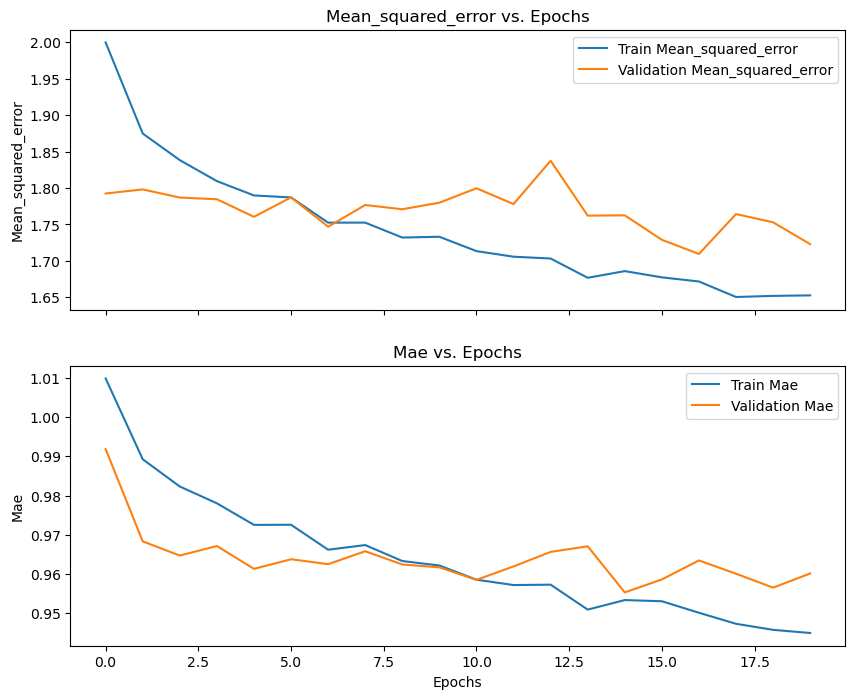

In [124]:
plot_metrics(history3, ["mean_squared_error", 'mae'])

132/132 [==============================] - 1s 4ms/step
MSE: 1.3231573006365804 MAE: 0.947540434725374
[[ 387  342  401]
 [ 133  254  645]
 [  86  262 1704]]
              precision    recall  f1-score   support

          -1       0.64      0.34      0.45      1130
           0       0.30      0.25      0.27      1032
           1       0.62      0.83      0.71      2052

    accuracy                           0.56      4214
   macro avg       0.52      0.47      0.47      4214
weighted avg       0.55      0.56      0.53      4214

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


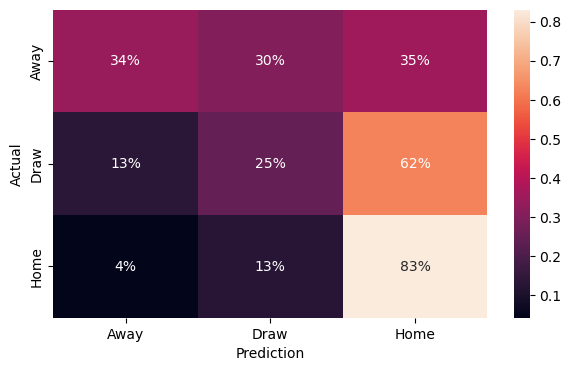

        home_team         away_team  home_score  away_score  home_xG  away_xG  \
2628  El Salvador          Honduras         2.0         2.0   1.1536   1.1364   
4022     Slovakia            Norway         0.0         1.0   1.2836   1.0023   
4196  Switzerland  Northern Ireland         2.0         1.0   1.7837   0.9105   
4192     Anguilla     French Guiana         0.0         5.0   0.5016   2.8801   
3055        Haiti       El Salvador         0.0         0.0   1.3545   0.7065   

      0  
2628  0  
4022  0  
4196  1  
4192 -1  
3055  1  


In [125]:
lstm_goals = lstm.predict(Xt_cat.to_numpy().reshape(-1, 1, input_shape))
print('MSE:', np.sqrt(mean_squared_error(yt, lstm_goals)), 'MAE:', mean_absolute_error(yt, lstm_goals))
lstm_preds = pd.DataFrame(np.round(lstm_goals, 4), columns=['home_xG', 'away_xG'])
accuracy, limit, lstm_win = -float('inf'), 0, None
lstm_win = lstm_preds.apply(lambda x: 0 if ((np.floor(x.home_xG) == np.floor(x.away_xG) and np.abs(x.home_xG-x.away_xG) <= 7/10) or\
    np.abs(x.home_xG-x.away_xG) <= 1/10) else 1 if x.home_xG > x.away_xG else -1, axis=1)
print(confusion_matrix(yt_win, lstm_win))
print(classification_report(yt_win, lstm_win))
plot_confusion_matrix(yt_win, lstm_win)

print(pd.concat([X_test[['home_team', 'away_team']].reset_index(drop=True), yt.reset_index(drop=True), lstm_preds.reset_index(drop=True), lstm_win], axis=1).sample(5))

In [148]:
lstm.save('./models/lstm_goals.h5')

### Predictions Euro

In [141]:
df_euros = pd.read_csv('./models/eruros.csv')
df_euros.head()

,home_team,away_team,neutral,importance,points_home,performance_home,gf_home,ga_home,home_points_home,home_performance_home,...,home_ga_away_recent,away_points_away_recent,away_performance_away_recent,away_gf_away_recent,away_ga_away_recent,neutral_points_away_recent,neutral_performance_away_recent,neutral_gf_away_recent,neutral_ga_away_recent,h2h
0,Albania,Spain,1,7,3996.0,0.30,0.96,1.52,1863.0,0.13,...,0.500000,345.0,0.228986,0.935484,1.967742,360.0,0.566667,1.888889,0.944444,-15.0
1,Croatia,Italy,1,7,4257.0,0.62,1.72,1.01,1380.0,0.75,...,0.552632,339.0,0.300885,0.933333,1.500000,144.0,0.597222,1.153846,1.076923,3.0
2,England,Slovenia,1,7,8841.0,0.68,2.14,0.97,3237.0,0.77,...,0.823529,348.0,0.589080,1.151515,1.242424,45.0,0.333333,1.000000,1.000000,12.0
3,Denmark,Serbia,1,7,7131.0,0.54,1.79,1.35,2877.0,0.65,...,1.115385,339.0,0.274336,1.000000,1.394737,243.0,0.246914,1.600000,1.400000,9.0
4,Netherlands,Austria,1,7,8043.0,0.65,2.07,1.22,3039.0,0.75,...,1.105263,363.0,0.454545,1.000000,1.343750,108.0,0.611111,1.500000,0.833333,6.0


In [142]:
X_in_cat = df_euros.drop(['home_team', 'away_team'], axis=1).reset_index(drop=True).replace([np.inf, -np.inf], 0.0)
X_in_cat = pd.concat([X_in_cat, pd.DataFrame(oh_encoder.transform(df_euros[['home_team', 'away_team']]).toarray(), 
                                               columns=oh_encoder.get_feature_names_out())], axis=1)
X_in_cat[scaled_cols] = mm_scaler.fit_transform(X_in_cat[scaled_cols])

In [145]:
goals = model1.predict(X_in_cat)
preds = pd.DataFrame(np.round(goals, 3), columns=['home_xG', 'away_xG'])
win = preds.apply(lambda x: 0 if ((np.floor(x.home_xG) == np.floor(x.away_xG) and np.abs(x.home_xG-x.away_xG) <= .6) or\
    np.abs(x.home_xG-x.away_xG) <= .1) else 1 if x.home_xG > x.away_xG else -1, axis=1)

pd.concat([df_euros[['home_team', 'away_team']].reset_index(drop=True), preds.reset_index(drop=True), win], axis=1)

1/1 [==============================] - 0s 28ms/step


,home_team,away_team,home_xG,away_xG,0
0,Albania,Spain,0.292,3.297,-1
1,Croatia,Italy,0.659,1.437,-1
2,England,Slovenia,3.045,0.341,1
3,Denmark,Serbia,1.901,1.060,1
4,Netherlands,Austria,1.628,0.916,1
5,France,Poland,1.580,1.345,0
6,Slovakia,Romania,0.815,1.727,-1
7,Ukraine,Belgium,0.459,2.601,-1
8,Georgia,Portugal,0.289,3.555,-1
9,Czech Republic,Turkey,1.435,1.400,0


In [146]:
goals = lstm.predict(X_in_cat.to_numpy().reshape(-1, 1, input_shape))
preds = pd.DataFrame(np.round(goals, 3), columns=['home_xG', 'away_xG'])
win = preds.apply(lambda x: 0 if ((np.floor(x.home_xG) == np.floor(x.away_xG) and np.abs(x.home_xG-x.away_xG) <= .6) or\
    np.abs(x.home_xG-x.away_xG) <= .1) else 1 if x.home_xG > x.away_xG else -1, axis=1)

pd.concat([df_euros[['home_team', 'away_team']].reset_index(drop=True), preds.reset_index(drop=True), win], axis=1)

1/1 [==============================] - 0s 30ms/step


,home_team,away_team,home_xG,away_xG,0
0,Albania,Spain,0.426,2.285,-1
1,Croatia,Italy,1.110,1.284,0
2,England,Slovenia,2.757,0.312,1
3,Denmark,Serbia,1.387,1.072,0
4,Netherlands,Austria,1.962,0.905,1
5,France,Poland,2.142,0.868,1
6,Slovakia,Romania,0.943,1.155,-1
7,Ukraine,Belgium,0.794,1.597,-1
8,Georgia,Portugal,0.091,2.672,-1
9,Czech Republic,Turkey,1.504,1.046,0


### Predicions Copa America

In [ ]:
df_euros = pd.read_csv('./models/america.csv')
df_euros.head()